In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Eliminating unecessary whitespaces around the saved figure.
plt.rcParams["savefig.bbox"] = "tight"

def plot(imgs, **imshow_kwargs):
  if not isinstance(imgs[0], list):
    imgs = [imgs]

  num_rows = len(imgs)
  num_cols = len(imgs[0])

  _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
  for row_idx, row in enumerate(imgs):
    for col_idx, img in enumerate(row):
      ax = axs[row_idx, col_idx]
      img = F.to_pil_image(img.to("cpu"))
      ax.imshow(np.asarray(img), **imshow_kwargs)
      ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  plt.tight_layout()

# **Reading Video Files From Torchvision.**

In [25]:
''' Reading videos. '''

import tempfile
from pathlib import Path
from urllib.request import urlretrieve

video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)

In [26]:
!pip install av

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


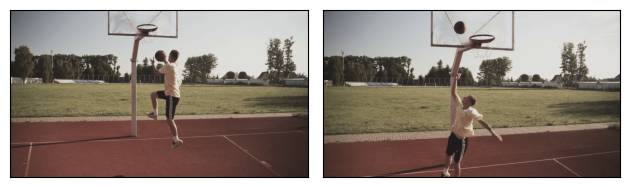

In [27]:
from torchvision.io import read_video

frames, _, _ = read_video( str(video_path), output_format="TCHW")

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

In [28]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()

def preprocess(img1_batch, img2_batch):
  img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
  img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)

  return transforms(img1_batch, img2_batch)

img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"Shape of img1_batch: {img1_batch.shape}, Data Type: {img1_batch.dtype}")
print(f"Shape of img2_batch: {img2_batch.shape}, Data Type: {img2_batch.dtype}")

Shape of img1_batch: torch.Size([2, 3, 520, 960]), Data Type: torch.float32
Shape of img2_batch: torch.Size([2, 3, 520, 960]), Data Type: torch.float32


# **Estimating Optical Flow Using RAFT Model**

In [31]:
from torchvision.models.optical_flow import raft_large

device = "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"Type = {type(list_of_flows)}")
print(f"Length = {len(list_of_flows)} = number of iterations of the model.")

Type = <class 'list'>
Length = 12 = number of iterations of the model.


In [32]:
predicted_flows = list_of_flows[-1]
print(f"Data Type = {predicted_flows.dtype}")
print(f"Shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"Min = {predicted_flows.min()}, Max = {predicted_flows.max()}")

Data Type = torch.float32
Shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
Min = -3.900778293609619, Max = 6.4004082679748535


# **Visualizing Predicted Flows**

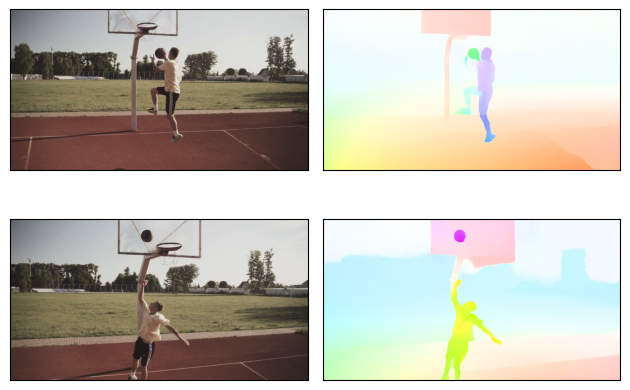

In [33]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped to [-1, 1] but for plotting, we want them as [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)